In [ ]:
import subprocess
import geopandas as gpd
import pandas as pd
import morecantile
import os
import time
import glob
from shapely import geometry, wkt, wkb
from shapely.ops import transform
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.plot import show as rio_show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import psycopg2
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
import asyncio
import requests
import aiohttp
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx
from concurrent.futures import ThreadPoolExecutor, as_completed
import cv2

# 1. Search for geopackages#
Pan-Arctic are split into 230 grids (shown in orange grids) to capture all the geopackages within the study area.
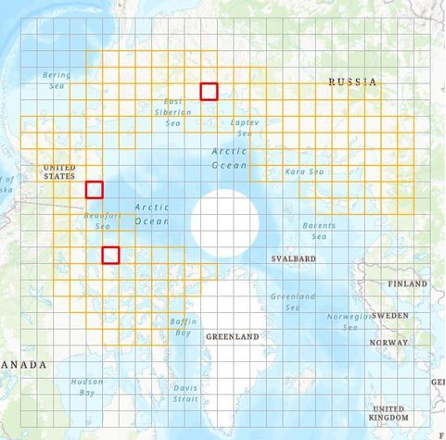

Our geopackages are organized under tilling system structure. For example, a geopackage is presented in this url: https://arcticdata.io/data/10.18739/A2KW57K57/iwp_geopackage_high/WGS1984Quad/15/4359/4192.gpkg
Which means the XYZ tilling information (as mentioned in Section 5) of this geopackage is: Z: 15, X: 4359, Y: 4192.

In order to get all geopackages, we use these grids to capture all geopakcages under the WGS1984 tilling system projection.

The 230 grids are originally created into 256*256km size with pixel resolution 1km in EPSG:3413. Then the grids are converted into EPSG: 4326. The bounding box of each grid will be used to search for geopackges based on their tilling information.


In [ ]:
def get_BBOX(x1, y1, x2, y2):
    # x1: xmin, y1: Ymin, x2: xmax, y2: ymax
    p1 = geometry.Point(x1, y1)
    p2 = geometry.Point(x1, y2)
    p3 = geometry.Point(x2, y2)
    p4 = geometry.Point(x2, y1)
    pointList = [p1, p2, p3, p4]
    poly = geometry.Polygon([[p.x, p.y] for p in pointList])

    return poly

In [ ]:
def get_all_tiles_XYZ(shpPath, tiles, tiles_output_path):
    gdf = gpd.read_file(shpPath)
    tms = morecantile.tms.get("WGS1984Quad")
    tiles_zxy = []
    for tile in tiles:
        tile_bounds = tms.bounds(tile)
        tile_geom = get_BBOX(tile_bounds.left, tile_bounds.bottom, tile_bounds.right, tile_bounds.top)
        if gdf["geometry"].intersects(tile_geom).any():
            tile_zxy = [tile.z, tile.x, tile.y]
            bbox = tms.bounds(tile)
            # print(f"The bbox of tile {tile_zxy} is: {bbox}")
            tiles_zxy.append(tile_zxy)

    with open(tiles_output_path, "w") as f:
        for tile in tiles_zxy:
            f.write(f"{tile[0]} {tile[1]} {tile[2]}\n")
    print(f"The number of tiles within the geographic bbox is: {len(tiles_zxy)}")
    print("----------------------------Get all tiles!-----------------------------")
    return tiles_zxy

In [ ]:
def get_all_tiles_within_Grid(shpPath, zoom_level, tiles_output_path):
    gdf = gpd.read_file(shpPath)
    xmin, ymin, xmax, ymax = gdf["geometry"].total_bounds
    # print(f"The xmin, ymin, xmax, ymax of the polygon is: {xmin, ymin, xmax, ymax}")
    tms = morecantile.tms.get("WGS1984Quad")
    tiles = tms.tiles(xmin, ymin, xmax, ymax, zoom_level)
    return get_all_tiles_XYZ(shpPath, tiles, tiles_output_path)

# 2. Install geopackages to local server#

As mentioned in the above section, the geopackage urls are organized based on their ZXY information. We can get the installation url based on this rule and download the data.

In [ ]:
def install_gpkg_from_urls(tiles_output_path, url_output_path, gridPath, ErrorurlPath):
    urls = []

    with open(tiles_output_path, "r") as f:
        for line in f:
            z, x, y = line.strip().split(" ")
            url = f'https://arcticdata.io/data/10.18739/A2KW57K57/iwp_geopackage_high/WGS1984Quad/{z}/{x}/{y}.gpkg'
            urls.append(url)

    returnNonEmptyTiles(urls, url_output_path, gridPath, ErrorurlPath)
    return urls

In order to record the error urls that have data but can’t be downloaded for some reasons, we add a log_error function to write down all data installation issues. If all the geopackages are installed successfully, then nothing will be written down.

In [ ]:
def log_error(error_type, url, mode, path):
    """Helper function to log errors."""
    with open(path, mode) as f:
        f.write(f"{error_type}: {url}\n")

We used wget to download geopackages and wrapped it into subprocess for python to deal with command line-based code.

Since the data installation can be interrupted due to various issues, such as internet connection issue, SSL issue, etc, we have to set a long timeout to prevent the installation from interrupting, and also set multiple retries to ensure the data installation will be retried if the install is interrupted.

Here we set timeout to 120, and retry to 30. Once the data is installed or there is no data in this tile, the code will iterate into next tile to search for data.


In [ ]:
def download_gpkg(url, url_output_path, gridPath, ErrorurlPath):
    """
    Download data from a URL until a 404 Not Found is confirmed or max retries are reached.

    Args:
        url (str): URL to fetch data from.
    Returns:
        Response object if successful; None if 404 or max retries exceeded.
    """

    # urllib python package, if failed, catch up the exception, and write the url to the file. After all files are downloaded.
    mode_url = "a" if os.path.exists(url_output_path) else "w"
    mode_error_url = "a" if os.path.exists(ErrorurlPath) else "w"

    retries = 0
    while retries < 30:
        try:
            response = requests.get(url, timeout=120)
            if response.status_code == 404:
                # print(f"404 Not Found: {url}")
                return None
            elif response.status_code == 200:
                try:
                    command = ['wget', '-r', '-np', '-nH', '--cut-dirs=6', '-R', r'\?C=', '-P', gridPath, url]
                    subprocess.run(command, check=True)
                    print(f"Success: {url}")
                    with open(url_output_path, mode_url) as f:
                        f.write(url + "\n")
                    return response
                except subprocess.CalledProcessError as e:
                    print(f"Download process error: {e}:{url} Retrying...")
            else:
                print(f"Received status code {response.status_code}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"Connection error: {e}:{url} Retrying...")
        retries += 1
        time.sleep(5)

    # If it still fails after 10 attempts, log the error
    log_error("Failed after 10 attempts", url, mode_error_url, ErrorurlPath)

In [ ]:
def returnNonEmptyTiles(urlList, url_output_path, gridPath, ErrorurlPath):
    """
    This function takes a list of urls within a selected grid and install all the geopackages within the grid.
    :param urlList: All the urls of the geopackages within the selected grid.
    :param existingTilesPath: All the geopackages that have been installed.
    :param dataPath: The installed geopackages data path.
    """
    start = time.time()
    # Remove the previous url files if exists
    for path in [url_output_path, ErrorurlPath]:
        if os.path.exists(path):
            os.remove(path)

    # Remove all the existing geopackages in the directory and also remove the directory itself
    if os.path.exists(gridPath):
        command = ['rm', '-rf', gridPath.rstrip("/")]
        try:
            subprocess.run(command, check=True)
            print(f"Files in {gridPath} removed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"Error removing files in {gridPath}: {e}")

    try:
        with ThreadPoolExecutor(max_workers=800) as executor:
            futures = {executor.submit(download_gpkg, url, url_output_path, gridPath, ErrorurlPath): url for url in urlList}
    except Exception as e:
        print(f"Error downloading the geopackages: {e}")

        # if os.path.exists(ErrorurlPath):
        #     with open(ErrorurlPah, "r") as f:
        #         f.read_file()

    if os.path.exists(gridPath):
        print(f"Geopackages installed successfully in {gridPath}")
        current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print(f"Current time: {current_time}")
        end = time.time()
        elapsed_time = end - start
        print(f"Elapsed time: {elapsed_time} seconds")
        print("----------------------------GPKG Installed!-----------------------------")
    else:
        print("----------------------------No data in this grid!----------------------------")


    return 0

# 3. Load geopackages into the database#
As introduced in the previous section, psql can be used to connect to database. After connecting to the database, we can load data downloaded in the remote server to the database using ogr2ogr.
Ogr2ogr is an SQL script which help us to convert simple features data between file format via terminal (To know more about ogr2ogr, please check out this).

In [ ]:
def load_gpkg_to_database(gridPath):
    print("Loading geopackages to the database...")
    # Directory path and other parameters
    flag = 0
    print(f"flag is: {flag}")
    start = time.time()

    # Iterate through the geopackage files in the directory
    # for gpkgPath in glob.glob(os.path.join(gridPath, '/*/*/*.gpkg')):
    for dirpath, dirnames, filenames in os.walk(gridPath):
        print(f"dirpath is: {dirpath}")
        print(f"dirnames is: {dirnames}")
        print(f"filenames is: {filenames}")
        for gpkgPath in filenames:
            print(f"Go to folder: {gpkgPath}")
            # Extracting the gpkg file name without extension
            gpkgName = os.path.splitext(os.path.basename(gpkgPath))[0]
            print(gpkgName)

            # PostgreSQL table name
            tableName = 'grid_gpkg_3413'

            # Set PostgreSQL password environment variable
            os.environ['PGPASSWORD'] = 'cicilab_asu'
            print(os.environ.get('PGPASSWORD'))

            if flag == 0:
                print(f"flag before creating is: {flag}")
                print("-------------------Creating A Table!------------------")
                # Run the ogr2ogr command to create a new table
                try:
                    # Run the command
                    subprocess.run([
                    'docker', 'exec', '-i', 'pdg_postgresql_gdal', 'ogr2ogr',
                    '-f', 'PostgreSQL',
                    'PG:dbname=postgres user=postgres',
                    os.path.join(dirpath, gpkgPath),
                    '-nln', tableName,
                    '-t_srs', 'EPSG:3413',
                    '-overwrite'
                    ], check=True, capture_output=True, text=True)
                    flag += 1
                    print(f"flag after creating is: {flag}")
                except subprocess.CalledProcessError as e:
                    pass

            else:
                print(f"flag before inserting is: {flag}")
                print("-------------------Inserting into the existing table!-----------------")
                # Run the ogr2ogr command to append to the existing table
                try:
                    # Run the command
                    subprocess.run([
                    'docker', 'exec', '-i', 'pdg_postgresql_gdal', 'ogr2ogr',
                    '-f', 'PostgreSQL',
                    'PG:dbname=postgres user=postgres',
                    os.path.join(dirpath, gpkgPath),
                    '-nln', tableName,
                    '-t_srs', 'EPSG:3413',
                    '-append'
                    ], check=True)
                    flag += 1
                    print(f"flag after creating is: {flag}")
                    # print(f'Container started successfully: {result.stdout.decode()}')
                except subprocess.CalledProcessError as e:
                    pass


    # End timer and print elapsed time
    end = time.time()
    print(f"Time elapsed: {int(end - start)} seconds")
    print("----------------------------GPKG Loaded!-----------------------------")
    return 0

# 4. Create polygon centroids and spatial index #

In order to create statistics values within each pixel, we will create a polygon centroid as geometry column in database, so IWPs with their centroids that fall within the pixel will count.

In the meantime, adding a spatial index on the centroid column will speed up querying process.

In [ ]:
def database_operation(hostname, database, user, password):
    # Establish connection to PostgreSQL
    conn = psycopg2.connect(
        host=hostname,
        database=database,
        user=user,
        password=password
    )

    # Create a cursor object
    cur = conn.cursor()

    sql_statements_dropColumn = """
        SET tcp_keepalives_idle = 20000;
        SET tcp_keepalives_interval = 20000;
        SET tcp_keepalives_count = 20000;
        SET statement_timeout = 0;
        SET idle_in_transaction_session_timeout = 0;
        ALTER TABLE grid_gpkg_3413
        DROP COLUMN geom_centroid;
    """

    sql_statements_addPoints = """
        SET tcp_keepalives_idle = 20000;
        SET tcp_keepalives_interval = 20000;
        SET tcp_keepalives_count = 20000;
        SET statement_timeout = 0;
        SET idle_in_transaction_session_timeout = 0;
        -- Uncomment this line if you want to alter the table
        -- ALTER TABLE grid_gpkg_3413 ADD COLUMN geom_centroid geometry(Point,3413);
        SELECT AddGeometryColumn('public', 'grid_gpkg_3413','geom_centroid',3413,'POINT',2);
    """

    sql_statements_convertPoints = """
        SET tcp_keepalives_idle = 20000;
        SET tcp_keepalives_interval = 20000;
        SET tcp_keepalives_count = 20000;
        SET statement_timeout = 0;
        SET idle_in_transaction_session_timeout = 0;
        DO $$ BEGIN
            RAISE NOTICE 'Starting to convert geometry column';
        END $$;

        UPDATE public.grid_gpkg_3413
        SET geom_centroid = ST_SetSRID(ST_Centroid(grid_gpkg_3413.geom), 3413);

        DO $$ BEGIN
            RAISE NOTICE 'Geometry column converted successfully';
        END $$;
    """

    sql_statements_dropIndex = """
        SET tcp_keepalives_idle = 20000;
        SET tcp_keepalives_interval = 20000;
        SET tcp_keepalives_count = 20000;
        SET statement_timeout = 0;
        SET idle_in_transaction_session_timeout = 0;
        DO $$ BEGIN
            RAISE NOTICE 'Starting to drop index';
        END $$;

        DROP INDEX idx_geom_centroid;

        DO $$ BEGIN
            RAISE NOTICE 'Index droped successfully';
        END $$;
    """


    sql_statements_createIndex = """
        SET tcp_keepalives_idle = 20000;
        SET tcp_keepalives_interval = 20000;
        SET tcp_keepalives_count = 20000;
        SET statement_timeout = 0;
        SET idle_in_transaction_session_timeout = 0;
        DO $$ BEGIN
            RAISE NOTICE 'Starting to create index';
        END $$;

        CREATE INDEX idx_geom_centroid ON grid_gpkg_3413 USING GIST (geom_centroid);

        DO $$ BEGIN
            RAISE NOTICE 'Index created successfully';
        END $$;
    """

    sql_statements_vacuum = """
        VACUUM ANALYZE grid_gpkg_3413;
    """

    # Execute the SQL statements
    try:
        # cur.execute(sql_statements_dropTable)
        # conn.commit()  # Commit the transaction
        # cur.execute(sql_statements_dropColumn)
        # conn.commit()  # Commit the transaction
        # print("Drop Column successfully")
        cur.execute(sql_statements_addPoints)
        conn.commit()  # Commit the transaction
    except Exception as e:
        print(f"An error occurred in adding points: {e}")
    try:
        conn.rollback()  # Roll back in case of error
        cur.execute(sql_statements_convertPoints)
        conn.commit()  # Commit the transaction
    except Exception as e:
        print(f"An error occurred in converting points: {e}")
        # cur.execute(sql_statements_dropIndex)
        # conn.commit()  # Commit the transaction
        # print("Drop Index successfully")
    try:
        cur.execute(sql_statements_createIndex)
        conn.commit()  # Commit the transaction
    except Exception as e:
        print(f"An error occurred in creating index: {e}")

    # Close the cursor and connection
    cur.close()
    conn.close()
    print("-----------------------------Database has been closed!-----------------------------")

    try:
        # Reconnect to the database to run VACUUM
        conn = psycopg2.connect(
            host=hostname,
            database=database,
            user=user,
            password=password
        )
        conn.autocommit = True
        cur = conn.cursor()

        cur.execute(sql_statements_vacuum)
        # conn.commit()  # Since VACUUM doesn't require a transaction, commit() is unnecessary and may cause unexpected behavior.
        print("Vacuum database successfully")
    except Exception as e:
        print(f"An error occurred in vacuuming database: {e}")

    # Close the cursor and connection
    cur.close()
    conn.close()
    print("----------------------------Database operation done!-----------------------------")
    return 0

In [ ]:
def set_up_connection(db_host, port, user, pwd, db):
    try:
        connection = psycopg2.connect(
        host=db_host,
        port=port,
        user=user,
        password=pwd,
        database=db,
        )
        # cursor = connection.cursor()
        print('Connection established successfully!')
        return connection
    except Exception as e:
        print("Error connecting to the database:", e)

# 5. Query IWPs from database#

This section construct the query and get all the satistified IWPs from the database.

In [ ]:
def sql_to_geodataframe(query, conn):
   # crs: Coordinate reference system to use for the returned GeoDataFrame
   pd.set_option('display.max_colwidth', None)
   geo_df = gpd.read_postgis(query, conn, geom_col='geom_centroid', crs="3413")
   # print(f"The geodataframe is: {geo_df}")
   return geo_df

In [ ]:
def get_centroids_within_bbox(bbox, col_names, conn):
    query = "SELECT " + col_names + " FROM grid_gpkg_3413 polygons WHERE ST_within(polygons.geom_centroid, ST_GeomFromText('" + bbox + "', 3413)) AND staging_duplicated = false"
    # print(f"The query is: {query}")
    geo_df = sql_to_geodataframe(query, conn)
    return geo_df, query

# 6. Plot statistics maps#

## 6.1. Grid rasterization ##
This step rasterize the grid into 256*256 raster of 1km pixels.

In [ ]:
def rasterize_polygon(bounds, pixel_size, output_path):
    # Calculate the width and height of the raster in pixels
    xmin, ymin, xmax, ymax = bounds
    # xmin = bounds.minx.values[0]
    # ymin = bounds.miny.values[0]
    # xmax = bounds.maxx.values[0]
    # ymax = bounds.maxy.values[0]
    # print(f"The polygon bounds of this ROI is: {polygon.bounds}")
    print(f"The polygon bounds of this ROI is: {xmin, ymin, xmax, ymax}")
    # polygon bounds is in meters, the pixel size is 1km x 1km
    print(f"The width size is: {xmax - xmin}")
    print(f"The height size is: {ymax - ymin}")
    # Calculate the width and height of the raster in pixels
    width = int((xmax - xmin) / pixel_size)
    height = int((ymax - ymin) / pixel_size)
    print(f"The height and width of this raster is: {height, width}")

    # Create an empty raster
    try:
        raster = rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=rasterio.uint8,
            crs='EPSG:3413',
            transform=from_origin(xmin, ymax, pixel_size, pixel_size)
        )
        raster.close()
        print(f"Raster created successfully!")
    except Exception as e:
        print(f"Error creating the raster: {e}")

    return raster, height, width

##6.2. Write down the rasters into GeoTiff files##
The grid is converted into rasters which contain various statistical information.

This can genereate a Geotiff file to store statistical values at the pixel level, while the raster is created at grid level.

In [ ]:
def create_sum_raster(original_raster, updated_raster, output_file):
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=updated_raster.shape[0],
        width=updated_raster.shape[1],
        count=1,
        dtype=np.float32,
        crs=original_raster.crs,
        transform=original_raster.transform,
    ) as dst:
        dst.write(updated_raster, 1)
    return dst

## 6.3. Raster calculation ##
This steps calculate the coverage ratio by diving the IWPs coverage sum by the pixel size (which is 1 quare kilometer).

In [ ]:
def calculate_coverage_ratio(sum_tif_file, ratio_tif_file, resolution):
    with rasterio.open(sum_tif_file, 'r') as raster:
        sum_raster = raster.read(1)
        with rasterio.open(
                ratio_tif_file,
                'w',
                driver='GTiff',
                height=sum_raster.shape[0],
                width=sum_raster.shape[1],
                count=1,
                dtype=np.float32,
                crs=raster.crs,
                transform=raster.transform,
            ) as src:
                # Calculate the coverage ratio by dividing the sum raster by the area of each cell (resolution * resolution)
                coverage_ratio_raster = sum_raster / (resolution * resolution)
                # Ensure the ratio does not exceed 1
                coverage_ratio_raster = np.minimum(coverage_ratio_raster, 1)
                print(f"The coverage ratio raster is: {coverage_ratio_raster}")
                src.write(coverage_ratio_raster, 1)

##6.4. Plot the rasters##

These steps read the statistics geotiff file, and plot out the statistics maps with smaller plotting height and weight.

In [ ]:
def height_width_adjust(height, width):
    new_height = int(height/10) if height > 10 else height
    new_width = int(width/10) if width > 10 else width
    return new_height, new_width

In [ ]:
def plot_raster(sum_tif_file, height, width, figure_path, plot_title, resolution):
    # Read the raster data
    with rasterio.open(sum_tif_file) as src:
        updated_raster = src.read(1)
        bounds = src.bounds

        plot_height, plot_width = height_width_adjust(height, width)
        print(f"The plot height and width is: {plot_height, plot_width}")

        extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
        print(f"The extent of the raster is: {extent}")

        # Create a masked array where 0 values are masked
        masked_raster = np.ma.masked_where(updated_raster == 0, updated_raster)

        # Plot the raster data with a color map using matplotlib
        plt.figure(figsize=(plot_width, plot_height))
        plt.title(f"{plot_title} - 1km")
        plt.imshow(masked_raster, extent=extent, cmap='viridis')
        plt.colorbar(label=plot_title)
        plt.xlabel('X (meters, EPSG:3413)')
        plt.ylabel('Y (meters, EPSG:3413)')
        plt.savefig(figure_path)
        plt.close()
        print("---------Plotting the raster data is done!---------")

    return 0

This step creates a statistics histogram showing the values distribution of each map, and also exclude 0 values in the map.

In [ ]:
def statistics_histogram(tif, output_path):
    with rasterio.open(tif) as src:
        updated_raster = src.read(1)
        print(f"The updated raster is: {updated_raster}")
        # Mask the 0 values in the raster data
        masked_raster = np.ma.masked_equal(updated_raster, 0)

        # # Flatten the masked array and remove the masked elements
        data = masked_raster.compressed()
        print(f"The data is: {data}")

        # Calculate the overall statistics for all heatmaps
        if data.size > 0:
            overall_min = np.min(data)
            overall_max = np.max(data)
            overall_mean = np.mean(data)
            overall_std = np.std(data)
            # Print the overall statistics
            print("Overall Min:", overall_min)
            print("Overall Max:", overall_max)
            print("Overall Mean:", overall_mean)
            print("Overall Standard Deviation:", overall_std)

            # Plot histogram
            plt.hist(data, bins=50, edgecolor='k', alpha=0.7)
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title('Histogram of the raster (excluding 0 values)')
            plt.savefig(output_path)
            plt.close()
        else:
            overall_min = overall_max = overall_mean = overall_std = None

## 6.5. Query from database to get values for each statistics map##

1) Create 5 rasters (256*256 size) to separately store IWP count, coverage sum, length sum, perimeter sum, and width sum at 1km-pixel level.

2) The coverage sum Geotiff file will be divided by pixel size to get the coverage ratio.

3) Each rasters will be plotted out.

In [ ]:
def draw_coverage_ratio(shpPath, connection, column_names, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path, pixel_size):
    # Create a polygon from the ROI, 4326 -> 3413
    # create_ROI(gdf, roi_path)
    gdf = gpd.read_file(shpPath)
    gdf = gdf.to_crs('EPSG:3413')
    polygon_bounds = gdf['geometry'].total_bounds
    print(f"The bounds of the polygon is: {polygon_bounds}")

    # Create a rasterized version of the polygon (ROI)
    original_raster, height, width = rasterize_polygon(polygon_bounds, pixel_size, rasterized_polygon_path)

    # Initialize dictionaries to store rasters and their corresponding sum values
    sum_rasters = {
        "Count": np.zeros((height, width), dtype=np.float32),
        "Coverage_Sum": np.zeros((height, width), dtype=np.float32),
        "Length_Sum": np.zeros((height, width), dtype=np.float32),
        "Perimeter_Sum": np.zeros((height, width), dtype=np.float32),
        "Width_Sum": np.zeros((height, width), dtype=np.float32)
    }

    # Iterate over each cell in the raster
    start = time.time()
    for row in range(height):
        for col in range(width):
            # Calculate the bounding box of the cell
            xmin, ymax = rasterio.transform.xy(original_raster.transform, row, col, offset='ul')
            xmax, ymin = rasterio.transform.xy(original_raster.transform, row + 1, col + 1, offset='ul')
            cell_bounds = (xmin, ymin, xmax, ymax)

            # cell bounds to bounding box
            bbox = f"POLYGON(({xmin} {ymin}, {xmin} {ymax}, {xmax} {ymax}, {xmax} {ymin}, {xmin} {ymin}))"
            # Get the centroids and areas within the bounding box from database
            geodf, query = get_centroids_within_bbox(bbox, column_names, connection)
            # print(f"The number of IWP within the bounding box is: {iwp_count}")

            # Store the sum values in the corresponding rasters
            sum_rasters["Count"][row, col] = len(geodf)
            sum_rasters["Coverage_Sum"][row, col] = geodf['area'].sum()
            sum_rasters["Length_Sum"][row, col] = geodf['length'].sum()
            sum_rasters["Perimeter_Sum"][row, col] = geodf['perimeter'].sum()
            sum_rasters["Width_Sum"][row, col] = geodf['width'].sum()

    end = time.time()
    print(f"The runtime of calculating coverage sum is {end - start}")

    # Save the updated raster arrays to new files
    for key, raster in sum_rasters.items():
        print(f"Creating raster for {key}")
        create_sum_raster(original_raster, raster, sum_raster_path.replace("coverage_sum", key))

     # Plot the new sum rasters
    for key in sum_rasters.keys():
        statistics_histogram(sum_raster_path.replace("coverage_sum", key),
                             histogram_path.replace("1km", key + "_1km"))
        plot_raster(sum_raster_path.replace("coverage_sum", key), height, width,
                    figure_path.replace("coverage_sum", key), key.replace("_", " "), pixel_size)

    # Calculate the coverage ratio of the cell
    calculate_coverage_ratio(sum_raster_path.replace("coverage_sum", "Coverage_Sum"), ratio_raster_path, pixel_size)
    statistics_histogram(ratio_raster_path, histogram_path.replace("1km", "Coverate_Ratio_1km"))

    # Plot the coverage ratio raster
    plot_raster(ratio_raster_path, height, width, figure_path.replace("coverage_sum", "Coverage_Ratio"), "Coverage Ratio", pixel_size)
    print("----------------------------statistics mapping done!-----------------------------")

#7. Iterate 230 grids to plot statistics maps#

230 grids will be iterated to get all the geopackages within Pan-Arctic area.

In [ ]:
def iterate_all_grids_to_mapping(shpDir):
    hostname = "cici.lab.asu.edu"
    port = "5432"
    user = "postgres"
    password = "cicilab_asu"
    database = "postgres"
    connection = set_up_connection(hostname, port, user, password, database)

    # Iterate all grids in the shapefile
    for _, _, filenames in os.walk(shpDir):
        filenames = sorted([f for f in filenames if f.endswith('.shp')])
        for filename in filenames:
            index = int(filename.split(".")[0])
            shpPath = os.path.join(shpDir, filename)
            gdf = gpd.read_file(shpPath)

            # This is exclude the unsual extent of the grid, which has bounds[2] = 180.00000001
            if gdf['geometry'].total_bounds[2] < 180:
                print(f"------------------------Processing Grid {index}......----------------------------")
                print(f"Grid {index}: {filename}")
                print(f"The bounds of the grid {index} is: {gdf['geometry'].total_bounds}")

                tilesPath = f"/home/xchen/data/geopackage/dataURLs/tiles_{index}.txt"
                urlPath = f"/home/xchen/data/geopackage/dataURLs/urls_{index}.txt"
                ErrorurlPath = f"/home/xchen/data/geopackage/dataURLs/ErrorURL_{index}.txt"
                gridTilespath = "/home/xchen/data/geopackage/Grid/"

                # Ensure directories exist
                os.makedirs(os.path.dirname(tilesPath), exist_ok=True)
                os.makedirs(os.path.dirname(urlPath), exist_ok=True)
                os.makedirs(os.path.dirname(ErrorurlPath), exist_ok=True)
                os.makedirs(gridTilespath, exist_ok=True)

                zoom_level = 15

                column = ["gid", "class", "sensor", "date", "time", "image", "area", "centroidx", "centroidy", "permeter", "length", "width", "geom_centroid"]
                column_names = "area, perimeter, length, width, geom_centroid"
                column_names_trough = "geom, geom_centroid"

                rootpath = "/home/xchen/data/output/Pan-Arctic/"

                rasterized_polygon_path = os.path.join(rootpath, f"ROI/ROI_1km_{index}.tiff")
                sum_raster_path = os.path.join(rootpath, f"RasterTIF/coverage_sum_1km_{index}.tif")
                ratio_raster_path = os.path.join(rootpath, f"RasterTIF/coverage_ratio_1km_{index}.tif")

                figure_path = os.path.join(rootpath, f"RasterPNG/coverage_sum_1km_{index}.png")
                histogram_path = os.path.join(rootpath, f"histogram/histogram_1km_{index}.png")
                array_path = os.path.join(rootpath, f"RasterTXT/coverage_sum_1km_{index}.txt")
                # roi_path = os.path.join(rootpath, "ROI/ROI.png")
                # query_path = os.path.join(rootpath, "validation/query.txt")

                output_IWP = os.path.join(rootpath, f"RasterTIF/IWP_raster_1km_{index}.tif")
                output_dilated = os.path.join(rootpath, f"RasterTIF/IWP_dilated_raster_1km_{index}.tif")
                output_difference = os.path.join(rootpath, f"RasterTIF/IWP_difference_raster_1km_{index}.tif")

                pixel_size = 1000
                subpixel_size = 1
                distance_threshold = 5

                get_all_tiles_within_Grid(shpPath, zoom_level, tilesPath)
                install_gpkg_from_urls(tilesPath, urlPath, gridTilespath, ErrorurlPath)
                if os.path.exists(gridTilespath):
                    load_gpkg_to_database(gridTilespath)
                    database_operation(hostname, database, user, password)
                    draw_coverage_ratio(shpPath, connection, column_names, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path, pixel_size)
                # write_tif_to_readable_file(sum_raster_path.replace("coverage", "length"),
                                # array_path.replace("coverage", "length"))
                # draw_coverage_ratio_from_tif(shpPath, pixel_size, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path)
                # calculate_trough_width(shpPath, connection, column_names_trough, rasterized_polygon_path, distance_threshold, figure_path, pixel_size, subpixel_size, output_IWP, output_dilated, output_difference)
            index += 1

    connection.close()


# (Optional) Write the Geotiff file into text file#

To quickly evaluate the values in the tiff file, we can convert it to a readable file for checking.

In [ ]:
def write_tif_to_readable_file(tif_path, output_file_path):
    with rasterio.open(tif_path) as src:
        data = src.read(1)  # Read the first band
        with open(output_file_path, 'w') as f:
            for row in data:
                f.write(' '.join(map(str, row)) + '\n')

# 8. Resample the GeoTiff file into any resolution #

Given a stride to downsample the tif images.

In [ ]:
def resample_coverage_ratio_from_tif(pixel_size, sum_raster_path, ratio_raster_path, figure_path, histogram_path):
    # Reopen the raster in read mode
    with rasterio.open(sum_raster_path, 'r') as src:
        bounds = src.bounds
        print(f"The bounds of the ROI are: {bounds}")
        original_raster = src.read(1)
        original_transform = src.transform
        original_crs = src.crs

        # Calculate new dimensions
        stride = int(pixel_size / 1000)
        print(f"The stride is: {stride}")
        new_height = original_raster.shape[0] // stride
        new_width = original_raster.shape[1] // stride
        print(f"The original height and width are: {original_raster.shape[0], original_raster.shape[1]}")
        print(f"The new height and width are: {new_height, new_width}")

        # Calculate new transform
        # Return an Affine transformation for a georeferenced raster given the coordinates of its upper left corner west, north and pixel sizes xsize, ysize.
        new_transform = rasterio.transform.from_origin(
            original_transform.c, original_transform.f, pixel_size, pixel_size
        )

        # Resample the raster to the new resolution
        temp_raster = np.zeros((new_height, new_width), dtype=np.float32)
        for i in range(new_height):
            for j in range(new_width):
                temp_raster[i, j] = np.sum(
                    # if stride = 2, [0, 0] -> [0:2, 0:2], [1, 0] -> [2:4, 0:2], [0, 1] -> [0:2, 2:4], [1, 1] -> [2:4, 2:4]
                    # if stride = 3, [0, 0] -> [0:3, 0:3], [1, 0] -> [3:6, 0:3], [0, 1] -> [0:3, 3:6], [1, 1] -> [3:6, 3:6]
                    original_raster[i*stride:(i+1)*stride, j*stride:(j+1)*stride]
                )

        # Update the metadata
        meta = src.meta.copy()
        meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform,
            "dtype": np.float32
        })

        # Write the resampled raster to a new file
        resampled_sum_raster_path = sum_raster_path.replace("1km.tif", str(stride)+ "km.tif")
        with rasterio.open(resampled_sum_raster_path, 'w', **meta) as dst:
            dst.write(temp_raster, 1)
        temp_raster = np.zeros_like(src.read(1), dtype=np.float32)

    # Calculate the coverage ratio of the cell
    resample_ratio_raster_path = ratio_raster_path.replace("1km.tif", str(stride)+ "km.tif")
    calculate_coverage_ratio(resampled_sum_raster_path, resample_ratio_raster_path, pixel_size)

    # Plot the new raster
    resample_figure_path = figure_path.replace("1km.png", str(stride)+ "km.png")
    plot_raster(resample_ratio_raster_path, bounds, new_height, new_width, resample_figure_path)

    # Plot the histogram
    # resampled_histogram_path = histogram_path.replace("_1km.png", "_2km.png")
    # statistics_histogram(ratio_raster_path, resampled_histogram_path)

In [ ]:
if __name__ == "__main__":
    shpPath_4326 = "/home/xchen/data/shapefile/Fishnet_230"
    iterate_all_grids_to_mapping(shpPath_4326)

    tilesPath = "/home/xchen/data/geopackage/dataURLs/tiles.txt"
    urlPath = "/home/xchen/data/geopackage/dataURLs/urls.txt"
    gridTilespath = "/home/xchen/data/geopackage/Grid/"
    ErrorurlPath = "/home/xchen/data/geopackage/dataURLs/ErrorURL.txt"
    zoom_level = 15

    hostname = "cici.lab.asu.edu"
    port = "5432"
    user = "postgres"
    password = "cicilab_asu"
    database = "postgres"

    column = ["gid", "class", "sensor", "date", "time", "image", "area", "centroidx", "centroidy", "permeter", "length", "width", "geom_centroid"]
    column_names = "area, perimeter, length, width, geom_centroid"
    column_names_trough = "geom, geom_centroid"

    rootpath = "/home/xchen/data/output/Pan-Arctic_2/"
    rasterized_polygon_path = rootpath + "ROI/ROI_1km.tiff"
    sum_raster_path = rootpath + "RasterTIF/coverage_sum_1km.tif"
    ratio_raster_path = rootpath + "RasterTIF/coverage_ratio_1km.tif"
    figure_path = rootpath + "RasterPNG/coverage_sum_1km.png"
    histogram_path = rootpath + "histogram/histogram_1km.png"
    array_path = rootpath + "RasterTXT/coverage_sum_array_1km.txt"
    roi_path = rootpath + "ROI/ROI.png"
    query_path = rootpath + "validation/query.txt"

    output_IWP = rootpath + "RasterTIF/IWP_raster_1km.tif"
    output_dilated = rootpath + "RasterTIF/IWP_dilated_raster_1km.tif"
    output_difference = rootpath + "RasterTIF/IWP_difference_raster_1km.tif"

    pixel_size = 1000
    subpixel_size = 1
    distance_threshold = 5